In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def eliminate_features_logistic_regression(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    important_features = utils.display_important_features(classifier.coef_[0], X,0)
    #important_features = display_important_features_regression(classifier, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [3]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001
tournament_season = 2003

In [4]:
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id_no_opp.csv'))

# drop opponent stat columns
summary_data.drop(columns=['allow_fg_pct','allow_ft_att_avg','allow_off_rebs_avg','allow_def_rebs_avg' ], inplace=True)
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(5687, 18)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
180,2000,New Orleans,e7ff6d5c-07e9-42af-955d-0a0b8c1e2288,29,-1.95,-3.83,0.586,69,65,0.457,0.680,NaN,NaN,NaN,15,7,NaN,22
398,2001,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,28,-14.55,-7.48,0.321,66,73,0.403,0.656,NaN,NaN,NaN,17,7,NaN,22
489,2001,Morris Brown,NaN,29,-26.38,-1.84,0.172,55,75,0.372,0.582,NaN,NaN,NaN,19,6,NaN,19
718,2002,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,29,-10.58,-10.30,0.586,71,71,0.431,0.677,NaN,NaN,NaN,17,7,NaN,24
811,2002,Morris Brown,NaN,28,-25.25,-10.21,0.286,63,75,0.405,0.629,NaN,NaN,NaN,16,6,NaN,22
983,2003,Birmingham-Southern,NaN,27,-3.27,-9.79,0.741,74,65,0.482,0.695,NaN,NaN,NaN,15,7,NaN,21
1043,2003,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,32,-9.85,-7.94,0.469,72,74,0.415,0.708,NaN,NaN,NaN,16,8,NaN,24
1308,2004,Birmingham-Southern,NaN,30,-7.24,-8.24,0.533,65,63,0.445,0.721,NaN,NaN,NaN,13,5,NaN,22
1368,2004,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,29,-15.06,-9.24,0.483,68,73,0.425,0.657,NaN,NaN,NaN,17,7,NaN,21
1633,2005,Birmingham-Southern,NaN,28,-5.81,-8.12,0.679,68,64,0.462,0.682,NaN,NaN,NaN,12,6,NaN,21


In [5]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(5673, 18)


In [6]:
summary_data.rename(str.lower, axis='columns', inplace=True)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [7]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [8]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


In [9]:
tourney_data[tourney_data['season']== tournament_season]

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id
61,2003,64,2003-03-21,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb
296,2003,64,2003-03-21,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a
329,2003,4,2003-04-05,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Texas,6ed15092-2670-450a-99c2-61d861e87644
334,2003,2,2003-04-07,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,2,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952
335,2003,64,2003-03-21,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,14,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502
336,2003,32,2003-03-23,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,6,Oklahoma State,8ab00d43-840a-4c96-bdee-bf88fa6e3f11
337,2003,8,2003-03-30,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Oklahoma,b2fda957-e15c-4fb2-8a13-6e58496f561e
343,2003,16,2003-03-28,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2
431,2003,32,2003-03-23,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b
432,2003,64,2003-03-21,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8


In [10]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)

game_data[game_data['season']==tournament_season]

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id,win_conf_name,lose_conf_name
61,2003,64,2003-03-21,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,Pacific 12,Pacific 12
296,2003,64,2003-03-21,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,Southeastern,Southland
329,2003,4,2003-04-05,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,Atlantic Coast,Big 12
334,2003,2,2003-04-07,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,2,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,Atlantic Coast,Big 12
335,2003,64,2003-03-21,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,14,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502,Atlantic Coast,Metro Atlantic Athletic
336,2003,32,2003-03-23,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,6,Oklahoma State,8ab00d43-840a-4c96-bdee-bf88fa6e3f11,Atlantic Coast,Big 12
337,2003,8,2003-03-30,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Oklahoma,b2fda957-e15c-4fb2-8a13-6e58496f561e,Atlantic Coast,Big 12
343,2003,16,2003-03-28,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,Atlantic Coast,Southeastern
431,2003,32,2003-03-23,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,Southeastern,Atlantic Coast
432,2003,64,2003-03-21,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,Southeastern,Atlantic 10


In [11]:
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [12]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

In [13]:


tourney_data = tourney_data[tourney_data['season'] >= tournament_season]
tourney_data.describe()['season']

count     981.000000
mean     2010.085627
std         4.325153
min      2003.000000
25%      2006.000000
50%      2010.000000
75%      2014.000000
max      2017.000000
Name: season, dtype: float64

In [14]:
tourney_data[tourney_data['season']==tournament_season]

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id
61,2003,64,2003-03-21,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb
296,2003,64,2003-03-21,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a
329,2003,4,2003-04-05,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Texas,6ed15092-2670-450a-99c2-61d861e87644
334,2003,2,2003-04-07,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,2,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952
335,2003,64,2003-03-21,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,14,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502
336,2003,32,2003-03-23,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,6,Oklahoma State,8ab00d43-840a-4c96-bdee-bf88fa6e3f11
337,2003,8,2003-03-30,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Oklahoma,b2fda957-e15c-4fb2-8a13-6e58496f561e
343,2003,16,2003-03-28,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2
431,2003,32,2003-03-23,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b
432,2003,64,2003-03-21,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8


In [15]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})


In [16]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data[tourney_data['season']== tournament_season]

,season,round,game_date,seed_t,team,team_id,seed_o,opp_team,opp_team_id,game_result,start_season,Game Result,school,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
17,2003,64,2003-03-21,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,1,2002,Win,Utah,33.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0
138,2003,64,2003-03-21,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,0,2002,Lose,Sam Houston State,30.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0
160,2003,4,2003-04-05,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,0,2002,Lose,Texas,33.0,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0
162,2003,2,2003-04-07,2,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,0,2002,Lose,Kansas,38.0,25.00,10.53,0.789,82.0,66.0,0.494,0.656,87.300000,14.0,27.0,14.0,9.0,93.928981,23.0
163,2003,64,2003-03-21,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,14,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502,1,2002,Win,Syracuse,35.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0
164,2003,32,2003-03-23,6,Oklahoma State,8ab00d43-840a-4c96-bdee-bf88fa6e3f11,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,0,2002,Lose,Oklahoma State,32.0,14.62,8.46,0.688,69.0,62.0,0.448,0.650,79.550000,12.0,24.0,14.0,8.0,86.737901,22.0
165,2003,8,2003-03-30,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Oklahoma,b2fda957-e15c-4fb2-8a13-6e58496f561e,1,2002,Win,Syracuse,35.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0
169,2003,16,2003-03-28,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,1,2002,Win,Syracuse,35.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0
198,2003,32,2003-03-23,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,0,2002,Lose,Wake Forest,31.0,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0
199,2003,64,2003-03-21,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,1,2002,Win,Auburn,34.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0


In [17]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))

tourney_data.drop(columns=['school_t','school_o','games_t','games_o','team_id_o'],inplace=True)

tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)

tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)


tourney_data[tourney_data['season_t']== tournament_season]

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
17,2003,64,2003-03-21,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,1,2002,Win,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,2002.0,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,Pacific 12,Pacific 12
138,2003,64,2003-03-21,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,-1,2002,Lose,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,2002.0,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,Southland,Southeastern
160,2003,4,2003-04-05,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,2002.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast
162,2003,2,2003-04-07,2,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,-1,2002,Lose,25.00,10.53,0.789,82.0,66.0,0.494,0.656,87.300000,14.0,27.0,14.0,9.0,93.928981,23.0,2002.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast
163,2003,64,2003-03-21,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,14,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502,1,2002,Win,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,2002.0,5.78,-1.99,0.767,75.0,68.0,0.447,0.788,81.246667,11.0,23.0,14.0,9.0,92.311479,23.0,Atlantic Coast,Metro Atlantic Athletic
164,2003,32,2003-03-23,6,Oklahoma State,8ab00d43-840a-4c96-bdee-bf88fa6e3f11,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,-1,2002,Lose,14.62,8.46,0.688,69.0,62.0,0.448,0.650,79.550000,12.0,24.0,14.0,8.0,86.737901,22.0,2002.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast
165,2003,8,2003-03-30,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Oklahoma,b2fda957-e15c-4fb2-8a13-6e58496f561e,1,2002,Win,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,2002.0,18.86,8.53,0.794,70.0,60.0,0.446,0.693,75.752941,12.0,24.0,12.0,6.0,92.405653,18.0,Atlantic Coast,Big 12
169,2003,16,2003-03-28,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,1,2002,Win,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,2002.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern
198,2003,32,2003-03-23,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,2002.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern
199,2003,64,2003-03-21,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,1,2002,Win,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,2002.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,Southeastern,Atlantic 10


In [18]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season'] >= tournament_season]
computer_rankings[computer_rankings.isnull().any(axis=1)]

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id


In [19]:
computer_rankings.describe()

,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR,season,win_pct
count,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000
mean,171.387055,171.340484,171.412725,171.364503,171.321782,171.310231,171.341217,171.283645,171.301247,2010.621746,0.513328
std,98.977414,98.926046,98.995735,98.973345,98.887448,98.906044,98.922645,98.868126,98.914325,4.595077,0.179117
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2003.000000,0.000000
25%,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,2007.000000,0.387097
50%,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,2011.000000,0.515152
75%,257.000000,257.000000,257.000000,257.000000,256.750000,257.000000,257.000000,256.000000,257.000000,2015.000000,0.645161
max,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,2018.000000,1.000000


In [20]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))
temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge[temp_merge['season_t']== tournament_season]

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR
17,2003,64,2003-03-21,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,1,2002,Win,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,2002.0,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,Pacific 12,Pacific 12,38,31.0,25,34,20.0,37.0,33.0,16.0,66
138,2003,64,2003-03-21,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,-1,2002,Lose,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,2002.0,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,Southland,Southeastern,138,102.0,115,143,87.0,134.0,93.0,91.0,169
160,2003,4,2003-04-05,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,2002.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,5,7.0,7,6,4.0,7.0,7.0,4.0,12
162,2003,2,2003-04-07,2,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,-1,2002,Lose,25.00,10.53,0.789,82.0,66.0,0.494,0.656,87.300000,14.0,27.0,14.0,9.0,93.928981,23.0,2002.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,4,4.0,12,5,7.0,4.0,11.0,6.0,2
163,2003,64,2003-03-21,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,14,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502,1,2002,Win,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,2002.0,5.78,-1.99,0.767,75.0,68.0,0.447,0.788,81.246667,11.0,23.0,14.0,9.0,92.311479,23.0,Atlantic Coast,Metro Atlantic Athletic,12,14.0,5,12,9.0,15.0,5.0,9.0,21
164,2003,32,2003-03-23,6,Oklahoma State,8ab00d43-840a-4c96-bdee-bf88fa6e3f11,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,-1,2002,Lose,14.62,8.46,0.688,69.0,62.0,0.448,0.650,79.550000,12.0,24.0,14.0,8.0,86.737901,22.0,2002.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,25,23.0,24,26,26.0,29.0,27.0,22.0,29
165,2003,8,2003-03-30,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Oklahoma,b2fda957-e15c-4fb2-8a13-6e58496f561e,1,2002,Win,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,2002.0,18.86,8.53,0.794,70.0,60.0,0.446,0.693,75.752941,12.0,24.0,12.0,6.0,92.405653,18.0,Atlantic Coast,Big 12,12,14.0,5,12,9.0,15.0,5.0,9.0,21
169,2003,16,2003-03-28,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,1,2002,Win,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,2002.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,12,14.0,5,12,9.0,15.0,5.0,9.0,21
198,2003,32,2003-03-23,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,2002.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,9,9.0,4,7,8.0,12.0,4.0,7.0,20
199,2003,64,2003-03-21,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,1,2002,Win,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,2002.0,14.61,3.71,

In [21]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)

tourney_comp_ratings.rename(str.lower, axis='columns', inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


In [22]:
tourney_comp_ratings[tourney_comp_ratings['season_t']== tournament_season ]

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o
17,2003,64,2003-03-21,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,1,2002,Win,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,2002.0,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,Pacific 12,Pacific 12,38,31.0,25,34,20.0,37.0,33.0,16.0,66,30,43.0,33,36,32.0,42.0,29.0,50.0,27
138,2003,64,2003-03-21,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,-1,2002,Lose,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,2002.0,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,Southland,Southeastern,138,102.0,115,143,87.0,134.0,93.0,91.0,169,7,11.0,11,10,14.0,6.0,8.0,15.0,7
160,2003,4,2003-04-05,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,2002.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21
162,2003,2,2003-04-07,2,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,-1,2002,Lose,25.00,10.53,0.789,82.0,66.0,0.494,0.656,87.300000,14.0,27.0,14.0,9.0,93.928981,23.0,2002.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,4,4.0,12,5,7.0,4.0,11.0,6.0,2,12,14.0,5,12,9.0,15.0,5.0,9.0,21
163,2003,64,2003-03-21,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,14,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502,1,2002,Win,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,2002.0,5.78,-1.99,0.767,75.0,68.0,0.447,0.788,81.246667,11.0,23.0,14.0,9.0,92.311479,23.0,Atlantic Coast,Metro Atlantic Athletic,12,14.0,5,12,9.0,15.0,5.0,9.0,21,69,48.0,62,77,52.0,63.0,57.0,55.0,88
164,2003,32,2003-03-23,6,Oklahoma State,8ab00d43-840a-4c96-bdee-bf88fa6e3f11,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,-1,2002,Lose,14.62,8.46,0.688,69.0,62.0,0.448,0.650,79.550000,12.0,24.0,14.0,8.0,86.737901,22.0,2002.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,25,23.0,24,26,26.0,29.0,27.0,22.0,29,12,14.0,5,12,9.0,15.0,5.0,9.0,21
165,2003,8,2003-03-30,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,1,Oklahoma,b2fda957-e15c-4fb2-8a13-6e58496f561e,1,2002,Win,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,2002.0,18.86,8.53,0.794,70.0,60.0,0.446,0.693,75.752941,12.0,24.0,12.0,6.0,92.405653,18.0,Atlantic Coast,Big 12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,8,8.0,6,9,3.0,9.0,6.0,3.0,6
169,2003,16,2003-03-28,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,1,2002,Win,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,2002.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,12,14.0,5,12,9.0,15.0,5.0,9.0,21,43,47.0,40,40,44.0,45.0,43.0,36.0,44
198,2003,32,2003-03-23,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,2002.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,

#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [23]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,-1,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,-1,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,-1,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,-1,Atlantic Coast,Atlantic 10,1
7,1,Atlantic 10,Big Ten,-1
8,-1,Big East,Atlantic 10,0
9,1,Atlantic 10,Pacific 12,-1


In [24]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [25]:
tourney_comp_ratings['margin_victory_avg_t'] = tourney_comp_ratings['pts_avg_t'] - tourney_comp_ratings['opp_pts_avg_t']
tourney_comp_ratings['margin_victory_avg_o'] = tourney_comp_ratings['pts_avg_o'] - tourney_comp_ratings['opp_pts_avg_o']

tourney_comp_ratings['delta_margin_victory_avg'] = tourney_comp_ratings['margin_victory_avg_t'] - \
    tourney_comp_ratings['margin_victory_avg_o']

tourney_comp_ratings['delta_fg_pct'] = tourney_comp_ratings['fg_pct_t'] - tourney_comp_ratings['fg_pct_o']

tourney_comp_ratings['delta_off_rebs_avg'] = tourney_comp_ratings['off_rebs_avg_t'] - tourney_comp_ratings['off_rebs_avg_o']

tourney_comp_ratings['delta_def_rebs_avg'] = tourney_comp_ratings['def_rebs_avg_t'] - tourney_comp_ratings['def_rebs_avg_o']


tourney_comp_ratings['delta_ft_pct'] = tourney_comp_ratings['ft_pct_t'] - tourney_comp_ratings['ft_pct_o']

tourney_comp_ratings['to_net_avg_t'] = tourney_comp_ratings['to_avg_t'] - tourney_comp_ratings['steal_avg_t']

tourney_comp_ratings['to_net_avg_o'] = tourney_comp_ratings['to_avg_o'] - tourney_comp_ratings['steal_avg_o']

tourney_comp_ratings['delta_to_net_avg'] = tourney_comp_ratings['to_net_avg_t'] - tourney_comp_ratings['to_net_avg_o']

tourney_comp_ratings['delta_win_pct'] = tourney_comp_ratings['win_pct_t'] - tourney_comp_ratings['win_pct_o']

tourney_comp_ratings['delta_off_rating'] = tourney_comp_ratings['off_rating_t'] - tourney_comp_ratings['off_rating_o']


tourney_comp_ratings['delta_ft_att_avg'] = tourney_comp_ratings['ft_att_avg_t'] - tourney_comp_ratings['ft_att_avg_o']

tourney_comp_ratings['delta_seed'] = tourney_comp_ratings['seed_t'] - tourney_comp_ratings['seed_o']

tourney_comp_ratings['delta_srs'] = tourney_comp_ratings['srs_t'] - tourney_comp_ratings['srs_o']
tourney_comp_ratings['delta_sos'] = tourney_comp_ratings['sos_t'] - tourney_comp_ratings['sos_o']

tourney_comp_ratings['delta_sag'] = tourney_comp_ratings['sag_t'] - tourney_comp_ratings['sag_o']
tourney_comp_ratings['delta_wlk'] = tourney_comp_ratings['wlk_t'] - tourney_comp_ratings['wlk_o']
tourney_comp_ratings['delta_wol'] = tourney_comp_ratings['wol_t'] - tourney_comp_ratings['wol_o']
tourney_comp_ratings['delta_rth'] = tourney_comp_ratings['rth_t'] - tourney_comp_ratings['rth_o']
tourney_comp_ratings['delta_col'] = tourney_comp_ratings['col_t'] - tourney_comp_ratings['col_o']
tourney_comp_ratings['delta_pom'] = tourney_comp_ratings['pom_t'] - tourney_comp_ratings['pom_o']
tourney_comp_ratings['delta_dol'] = tourney_comp_ratings['dol_t'] - tourney_comp_ratings['dol_o']
tourney_comp_ratings['delta_rpi'] = tourney_comp_ratings['rpi_t'] - tourney_comp_ratings['rpi_o']
tourney_comp_ratings['delta_mor'] = tourney_comp_ratings['mor_t'] - tourney_comp_ratings['mor_o']


tourney_comp_ratings.drop(columns=['season_o'], inplace=True)


In [26]:
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
513,2004,68,2004-03-16,16,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,16,Lehigh,508f503f-dc57-4f4c-a01e-4f195e5c05c8,1,2003,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.30,-8.88,0.645,67.0,63.0,0.424,0.716,77.612903,11.0,25.0,14.0,7.0,86.325852,19.0,Mid Eastern Athletic,Patriot League,287,275.0,287,289,261.0,276.0,276.0,262.0,255,222,194.0,204,224,181.0,218.0,182.0,194.0,212,0,0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,0,NaN,NaN,65,81.0,83,65,80.0,58.0,94.0,68.0,43
614,2004,64,2004-03-19,16,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,1,Kentucky,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1,-1,2003,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.83,8.55,0.844,73.0,63.0,0.472,0.697,79.587500,11.0,24.0,14.0,7.0,91.722946,19.0,Mid Eastern Athletic,Southeastern,287,275.0,287,289,261.0,276.0,276.0,262.0,255,4,3.0,2,3,1.0,4.0,5.0,2.0,2,-1,1,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,15,NaN,NaN,283,272.0,285,286,260.0,272.0,271.0,260.0,253
947,2007,68,2007-03-13,16,Niagara,f7575278-12ec-494a-b544-427c1759d43d,16,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,1,2006,Win,-3.41,-4.7,0.657,75.0,74.0,0.418,0.731,83.645714,14.0,23.0,13.0,6.0,89.663889,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Metro Atlantic Athletic,Mid Eastern Athletic,162,152.0,152,173,142.0,169.0,138.0,136.0,143,231,204.0,180,235,180.0,256.0,208.0,171.0,248,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,-69,-52.0,-28,-62,-38.0,-87.0,-70.0,-35.0,-105


In [28]:
tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [29]:
numeric_feature_to_scale = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor']

scaler =StandardScaler()
tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,7.0,5.0,0.332873,2.151311,-0.040958,1.146687,-0.827320,6.0,3.0,1.153581,-0.133712,0.821270,0.809479,-0.137292,0.435331,0.282886,-0.436811,-0.492200,0.002406,-0.264534,-0.141820,-0.476641,-0.212825,-0.148422,-0.376340
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,8.0,1.0,1.149197,0.248976,0.744473,1.146687,-0.511612,4.0,6.0,-0.820181,1.515237,0.042596,0.809479,-0.405032,0.035614,-1.059702,-0.191069,-0.194525,-0.305910,-0.073812,-0.207183,-0.013295,-0.228442,-0.165936,0.251960
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,9.0,12.0,-0.483451,0.153860,-0.433674,1.146687,-1.143027,6.0,0.0,2.337838,0.289470,-0.596421,0.533347,0.933668,-0.789986,-0.631651,0.517247,0.557496,0.391857,0.430239,0.364742,0.479010,0.224450,0.306944,0.607086
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9.0,15.0,-0.973245,-2.287469,0.744473,-2.348167,-1.241685,1.0,6.0,-2.004438,-0.075342,-1.612304,0.257215,0.933668,-0.776452,-0.468028,0.575068,0.510494,0.245813,0.511976,0.381082,0.536928,0.271301,0.447057,0.620744
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,17.0,5.0,1.965521,2.341544,0.351758,2.311638,-0.708929,6.0,3.0,1.153581,1.624681,1.051155,0.533347,-1.342121,1.404396,0.556078,-1.087304,-0.836876,-0.841405,-0.986552,-0.958854,

In [30]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,7.0,5.0,0.332873,2.151311,-0.040958,1.146687,-0.827320,6.0,3.0,1.153581,-0.133712,0.821270,0.809479,-0.137292,0.435331,0.282886,-0.436811,-0.492200,0.002406,-0.264534,-0.141820,-0.476641,-0.212825,-0.148422,-0.376340
1,2011,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,8.0,1.0,1.149197,0.248976,0.744473,1.146687,-0.511612,4.0,6.0,-0.820181,1.515237,0.042596,0.809479,-0.405032,0.035614,-1.059702,-0.191069,-0.194525,-0.305910,-0.073812,-0.207183,-0.013295,-0.228442,-0.165936,0.251960
2,2013,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,9.0,12.0,-0.483451,0.153860,-0.433674,1.146687,-1.143027,6.0,0.0,2.337838,0.289470,-0.596421,0.533347,0.933668,-0.789986,-0.631651,0.517247,0.557496,0.391857,0.430239,0.364742,0.479010,0.224450,0.306944,0.607086
3,2012,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9.0,15.0,-0.973245,-2.287469,0.744473,-2.348167,-1.241685,1.0,6.0,-2.004438,-0.075342,-1.612304,0.257215,0.933668,-0.776452,-0.468028,0.575068,0.510494,0.245813,0.511976,0.381082,0.536928,0.271301,0.447057,0.620744
4,2011,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,17.0,5.0,1.965521,2.341544,0.351758,2.311638,-0.708929,6.0,3.0,1.153581,1.624681,1.051155,0.533347,-1.342121,1.404396,0.556078,-1.087304,-0.836876,-0.841405,-0.986552,-0.958854,-1.171659,-1.102993,-0.848986,-1.045616


In [31]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)




feature_data.head()

,season_t,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,1,0,0.332873,2.151311,-0.040958,1.146687,-0.827320,1.153581,-0.133712,0.821270,0.809479,-0.137292,0.435331,0.282886,-0.436811,-0.492200,0.002406,-0.264534,-0.141820,-0.476641,-0.212825,-0.148422,-0.376340
1,2011,-1,0,1.149197,0.248976,0.744473,1.146687,-0.511612,-0.820181,1.515237,0.042596,0.809479,-0.405032,0.035614,-1.059702,-0.191069,-0.194525,-0.305910,-0.073812,-0.207183,-0.013295,-0.228442,-0.165936,0.251960
2,2013,0,1,-0.483451,0.153860,-0.433674,1.146687,-1.143027,2.337838,0.289470,-0.596421,0.533347,0.933668,-0.789986,-0.631651,0.517247,0.557496,0.391857,0.430239,0.364742,0.479010,0.224450,0.306944,0.607086
3,2012,0,1,-0.973245,-2.287469,0.744473,-2.348167,-1.241685,-2.004438,-0.075342,-1.612304,0.257215,0.933668,-0.776452,-0.468028,0.575068,0.510494,0.245813,0.511976,0.381082,0.536928,0.271301,0.447057,0.620744
4,2011,1,1,1.965521,2.341544,0.351758,2.311638,-0.708929,1.153581,1.624681,1.051155,0.533347,-1.342121,1.404396,0.556078,-1.087304,-0.836876,-0.841405,-0.986552,-0.958854,-1.171659,-1.102993,-0.848986,-1.045616


In [32]:
X= feature_data[feature_data['season_t']>=tournament_season]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>=tournament_season]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['top_conf',
 'upset_seed_threshold',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 23)
(782,)
(196, 23)
(196,)


,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
783,0,1,-0.973245,-1.780180,0.744473,-1.183215,-0.412954,-0.030676,-1.213555,-1.484447,0.257215,1.067537,-0.361396,0.360314,0.314871,0.306822,0.683946,0.525599,0.430104,0.290775,0.474322,0.341973,0.197325
123,-1,0,0.332873,0.122154,0.744473,-0.794898,-0.412954,-0.425428,0.479172,-0.018124,-0.571181,0.130448,-0.256730,-0.539613,0.358237,0.338156,0.034860,0.266763,0.021587,0.218378,0.271301,0.026719,0.210983
234,-1,1,-0.483451,0.058743,0.351758,1.146687,-0.038051,1.153581,-0.374488,-0.709755,-0.295049,1.067537,-0.635694,-0.621425,0.560613,0.573163,0.651491,0.593714,0.577171,0.536928,0.849129,0.674740,0.279277
718,-1,0,-0.320186,0.724560,-0.826389,0.758370,-0.866783,1.153581,-0.651745,-0.234519,-0.571181,0.532058,-0.274776,-0.244507,0.257049,0.291155,0.391857,0.280386,0.413764,0.232857,0.286918,0.412029,0.074397
807,-1,0,-0.320186,0.597738,-0.040958,0.758370,-0.176173,0.364076,-0.046157,-0.289274,0.809479,0.398188,-0.141236,-0.041439,0.184772,0.212819,0.326949,0.253140,0.201335,0.247337,0.240067,0.026719,0.429523


In [34]:
# mark the records used for training
#tourney_comp_ratings['train_rec'] = 0
#tourney_comp_ratings.loc[X_train.index,'train_rec']= 1
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,7.0,5.0,0.332873,2.151311,-0.040958,1.146687,-0.827320,6.0,3.0,1.153581,-0.133712,0.821270,0.809479,-0.137292,0.435331,0.282886,-0.436811,-0.492200,0.002406,-0.264534,-0.141820,-0.476641,-0.212825,-0.148422,-0.376340
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,8.0,1.0,1.149197,0.248976,0.744473,1.146687,-0.511612,4.0,6.0,-0.820181,1.515237,0.042596,0.809479,-0.405032,0.035614,-1.059702,-0.191069,-0.194525,-0.305910,-0.073812,-0.207183,-0.013295,-0.228442,-0.165936,0.251960
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,9.0,12.0,-0.483451,0.153860,-0.433674,1.146687,-1.143027,6.0,0.0,2.337838,0.289470,-0.596421,0.533347,0.933668,-0.789986,-0.631651,0.517247,0.557496,0.391857,0.430239,0.364742,0.479010,0.224450,0.306944,0.607086
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9.0,15.0,-0.973245,-2.287469,0.744473,-2.348167,-1.241685,1.0,6.0,-2.004438,-0.075342,-1.612304,0.257215,0.933668,-0.776452,-0.468028,0.575068,0.510494,0.245813,0.511976,0.381082,0.536928,0.271301,0.447057,0.620744
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,17.0,5.0,1.965521,2.341544,0.351758,2.311638,-0.708929,6.0,3.0,1.153581,1.624681,1.051155,0.533347,-1.342121,1.404396,0.556078,-1.087304,-0.836876,-0.841405,-0.986552,-0.958854,

#### Baseline Model

In [35]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[-0.30403825  0.18966213 -0.84688633 -0.07084135  0.15647888 -0.0297209
  -0.01626502 -0.07908041  3.51766056  0.09447949 -0.18667257  1.1835379
   2.48841383  3.44626696 -0.19914944 -0.6760266  -0.77644324  1.35535818
   1.93972024  0.3194151   1.96950621  0.29492372 -0.10890372]]
Intercept  [-0.09902137]


In [36]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   3.517660561944367
delta_sos   3.4462669607472582
delta_srs   2.4884138333488726
delta_dol   1.9695062141883304
delta_col   1.9397202372385085
delta_rth   1.355358182237335
delta_seed   1.18353790139612
delta_margin_victory_avg   -0.8468863307611855
delta_wol   -0.7764432374234461
delta_wlk   -0.6760266047871026
delta_pom   0.31941510109827875
top_conf   -0.3040382487679435
delta_rpi   0.29492372356011964
delta_sag   -0.19914944482892638
upset_seed_threshold   0.18966212506546626
delta_ft_att_avg   -0.18667257273436283
delta_off_rebs_avg   0.15647888172093508
delta_mor   -0.10890371672779005
delta_off_rating   0.09447948894334707
delta_to_net_avg   -0.07908041191919284
delta_fg_pct   -0.07084135071222424
delta_def_rebs_avg   -0.029720898750607058
delta_ft_pct   -0.016265016592780696


[('delta_win_pct', 3.517660561944367),
 ('delta_sos', 3.4462669607472582),
 ('delta_srs', 2.4884138333488726),
 ('delta_dol', 1.9695062141883304),
 ('delta_col', 1.9397202372385085),
 ('delta_rth', 1.355358182237335),
 ('delta_seed', 1.18353790139612),
 ('delta_margin_victory_avg', -0.8468863307611855),
 ('delta_wol', -0.7764432374234461),
 ('delta_wlk', -0.6760266047871026),
 ('delta_pom', 0.31941510109827875),
 ('top_conf', -0.3040382487679435),
 ('delta_rpi', 0.29492372356011964),
 ('delta_sag', -0.19914944482892638),
 ('upset_seed_threshold', 0.18966212506546626),
 ('delta_ft_att_avg', -0.18667257273436283),
 ('delta_off_rebs_avg', 0.15647888172093508),
 ('delta_mor', -0.10890371672779005),
 ('delta_off_rating', 0.09447948894334707),
 ('delta_to_net_avg', -0.07908041191919284),
 ('delta_fg_pct', -0.07084135071222424),
 ('delta_def_rebs_avg', -0.029720898750607058),
 ('delta_ft_pct', -0.016265016592780696)]

In [37]:
y_pred = logreg.predict(X_test)


array([[81, 14],
       [13, 88]], dtype=int64)

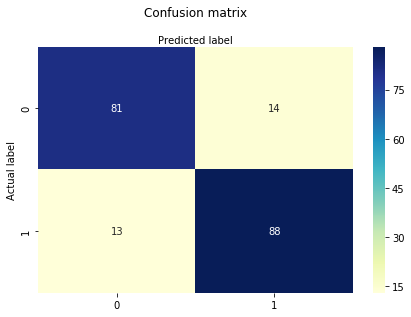

In [38]:
utils.display_confusion_matrix(y_test, y_pred)

In [39]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.8622448979591837
Precision: 0.8627450980392157
Recall: 0.8712871287128713
Log loss=  0.3814866221036834


In [40]:
scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.8230591205554386


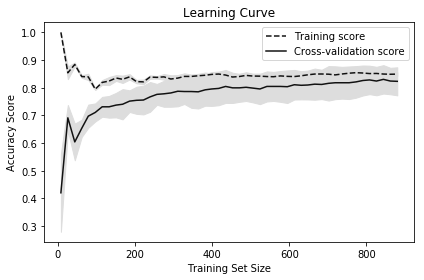

In [41]:
train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Model Feature Optimization

In [42]:
X = feature_data[feature_data['season_t']>= tournament_season]
X = X.drop(columns=['season_t'])
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=tournament_season]['game_result']

model_stats = eliminate_features_logistic_regression(logreg, X,y)

Iteration=  0
least_important label=  delta_ft_pct
Iteration=  1
least_important label=  delta_def_rebs_avg
Iteration=  2
least_important label=  delta_fg_pct
Iteration=  3
least_important label=  delta_to_net_avg
Iteration=  4
least_important label=  delta_off_rating
Iteration=  5
least_important label=  delta_mor
Iteration=  6
least_important label=  delta_off_rebs_avg
Iteration=  7
least_important label=  delta_ft_att_avg
Iteration=  8
least_important label=  upset_seed_threshold
Iteration=  9
least_important label=  delta_sag
Iteration=  10
least_important label=  delta_rpi
Iteration=  11
least_important label=  top_conf
Iteration=  12
least_important label=  delta_pom
Iteration=  13
least_important label=  delta_wlk
Iteration=  14
least_important label=  delta_wol
Iteration=  15
least_important label=  delta_margin_victory_avg
Iteration=  16
least_important label=  delta_seed
Iteration=  17
least_important label=  delta_rth
Iteration=  18
least_important label=  delta_col
Iteratio

In [43]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.8622 Cross Val= 0.8231  Log Loss= 0.3815
Accuracy= 0.8622 Cross Val= 0.8261  Log Loss= 0.3816
Accuracy= 0.8571 Cross Val= 0.8272  Log Loss= 0.3822
Accuracy= 0.8622 Cross Val= 0.8292  Log Loss= 0.3815
Accuracy= 0.8571 Cross Val= 0.8353  Log Loss= 0.3816
Accuracy= 0.8622 Cross Val= 0.8353  Log Loss= 0.3808
Accuracy= 0.8571 Cross Val= 0.8353  Log Loss= 0.3817
Accuracy= 0.8673 Cross Val= 0.8374  Log Loss= 0.3770
Accuracy= 0.8520 Cross Val= 0.8364  Log Loss= 0.3806
Accuracy= 0.8520 Cross Val= 0.8312  Log Loss= 0.3783
Accuracy= 0.8520 Cross Val= 0.8343  Log Loss= 0.3785
Accuracy= 0.8622 Cross Val= 0.8374  Log Loss= 0.3759
Accuracy= 0.8622 Cross Val= 0.8343  Log Loss= 0.3732
Accuracy= 0.8622 Cross Val= 0.8374  Log Loss= 0.3728
Accuracy= 0.8571 Cross Val= 0.8333  Log Loss= 0.3753
Accuracy= 0.8571 Cross Val= 0.8292  Log Loss= 0.3808
Accuracy= 0.8469 Cross Val= 0.8251  Log Loss= 0.3862
Accuracy= 0.8265 Cross Val= 0.8098  Log Loss= 0.4163
Accuracy= 0.8214 Cross Val= 0.8108  Log Loss= 

In [44]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['top_conf', 'upset_seed_threshold', 'delta_margin_victory_avg', 'delta_win_pct', 'delta_ft_att_avg', 'delta_seed', 'delta_srs', 'delta_sos', 'delta_sag', 'delta_wlk', 'delta_wol', 'delta_rth', 'delta_col', 'delta_pom', 'delta_dol', 'delta_rpi']


In [45]:
X = feature_data[feature_data['season_t']>= tournament_season][model_features]

array([[82, 13],
       [13, 88]], dtype=int64)

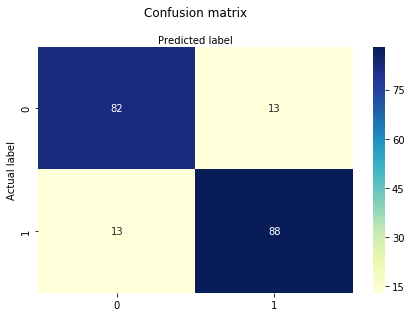

In [46]:
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=tournament_season]['game_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
# save model stats
prediction_probabilities = logreg.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
log_loss_value = log_loss(y_test, prediction_probabilities)
cross_val_scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
utils.display_confusion_matrix(y_test, y_pred)



In [47]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   3.5067710630361235
delta_sos   3.4991087173615254
delta_srs   2.530929402683857
delta_dol   1.9833840201235846
delta_col   1.9430165292556756
delta_rth   1.4240513246944153
delta_seed   1.190347205156702
delta_wol   -0.8273359352242735
delta_margin_victory_avg   -0.8049104920091154
delta_wlk   -0.7379739467118995
delta_rpi   0.3363162526319061
top_conf   -0.3167773754744068
delta_pom   0.26476599643508836
delta_sag   -0.20945706475055262
upset_seed_threshold   0.18423242993811562
delta_ft_att_avg   -0.14409908754940315


[('delta_win_pct', 3.5067710630361235),
 ('delta_sos', 3.4991087173615254),
 ('delta_srs', 2.530929402683857),
 ('delta_dol', 1.9833840201235846),
 ('delta_col', 1.9430165292556756),
 ('delta_rth', 1.4240513246944153),
 ('delta_seed', 1.190347205156702),
 ('delta_wol', -0.8273359352242735),
 ('delta_margin_victory_avg', -0.8049104920091154),
 ('delta_wlk', -0.7379739467118995),
 ('delta_rpi', 0.3363162526319061),
 ('top_conf', -0.3167773754744068),
 ('delta_pom', 0.26476599643508836),
 ('delta_sag', -0.20945706475055262),
 ('upset_seed_threshold', 0.18423242993811562),
 ('delta_ft_att_avg', -0.14409908754940315)]

In [48]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.8673469387755102
Precision: 0.8712871287128713
Recall: 0.8712871287128713
Log loss=  0.37697262842130713


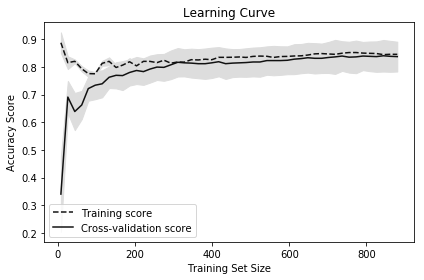

In [49]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [50]:
# Retrieve the non-normalized game stats
prediction_probabilities = logreg.predict_proba(X_test)
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9.0,15.0,-6.0,-0.072,2.0,-6.0,-0.063,1.0,6.0,-5.0,-0.012,-10.243325,1.0,7.0,-8.63,-3.17,40.0,33.0,16.0,38.0,24.0,37.0,18.0,26.0,45.0,-1,0.421841
11,2013,64,2013-03-21,8,Colorado State,1a470730-f328-4fb1-8bbf-36a069e4d6b2,9,Missouri,77ca152a-cb2f-48a5-97b2-492351250d94,1,2012,Win,13.65,5.89,0.743,72.0,63.0,0.449,0.715,76.914286,14.0,22.0,11.0,4.0,93.610698,24.0,15.41,6.00,0.676,76.0,66.0,0.459,0.744,80.570588,13.0,23.0,13.0,6.0,94.327225,20.0,Mountain West,Southeastern,36,29.0,21,32,22.0,24.0,28.0,21.0,40,16,24.0,46,36,44.0,18.0,36.0,36.0,17,-1,0,9.0,10.0,-1.0,-0.010,1.0,-1.0,-0.029,7.0,7.0,0.0,0.067,-0.716527,4.0,-1.0,-1.76,-0.11,20.0,5.0,-25.0,-4.0,-22.0,6.0,-8.0,-15.0,23.0,1,0.602104
12,2017,64,2017-03-17,6,Creighton,7d797407-623e-476d-b299-46de4275414d,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,-1,2016,Lose,17.27,8.95,0.714,81.0,72.0,0.504,0.682,80.251429,8.0,26.0,12.0,6.0,100.932783,16.0,12.88,4.62,0.714,73.0,65.0,0.454,0.668,77.840000,11.0,25.0,11.0,6.0,93.782117,22.0,Big East,Atlantic 10,27,26.0,22,23,22.0,27.0,25.0,26.0,27,48,40.0,48,53,43.0,37.0,52.0,31.0,31,0,0,9.0,8.0,1.0,0.050,-3.0,1.0,0.014,6.0,5.0,1.0,0.000,7.150666,-6.0,-5.0,4.39,4.33,-21.0,-14.0,-26.0,-30.0,-21.0,-10.0,-27.0,-5.0,-4.0,1,0.700281
23,2010,16,2010-03-26,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,10,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,1,2009,Win,17.97,8.03,0.778,76.0,65.0,0.487,0.725,78.427778,12.0,26.0,13.0,6.0,96.904441,20.0,13.38,2.20,0.824,78.0,66.0,0.484,0.761,76.611765,10.0,25.0,11.0,4.0,101.812039,19.0,Big 12,West Coast,8,13.0,12,10,13.0,12.0,10.0,9.0,11,30,29.0,27,28,27.0,43.0,30.0,35.0,49,1,1,11.0,12.0,-1.0,0.003,2.0,1.0,-0.036,7.0,7.0,0.0,-0.046,-4.907598,1.0,-7.0,4.59,5.83,-22.0,-16.0,-15.0,-18.0,-14.0,-31.0,-20.0,-26.0,-38.0,1,0.589843
28,2014,32,2014-03-23,3,Creighton,7d797407-623e-476d-b299-46de4275414d,6,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,-1,2013,Lose,18.03,7.17,0.771,78.0,67.0,0.497,0.743,72.302857,8.0,25.0,9.0,3.0,107.879554,18.0,15.80,10.11,0.684,74.0,67.0,0.455,0.680,77.042105,13.0,24.0,11.0,5.0,96.051373,24.0,Big East,Big 12,11,6.0,12,11,10.0,9.0,16.0,10.0,10,29,30.0,27,25,28.0,31.0,26.0,30.0,27,-1,0,11.0,7.0,4.0,0.042,-5.0,1.0,0.063,6.0,6.0,0.0,0.087,11.828181,-6.0,-3.0,2.23,-2.94,-18.0,-24.0,-15.0,-14.0,-18.0,-22.0,-10.0,-20.0,-17.0,-1,0.465792


In [51]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])

missed_predictions

Missed predictions=  26


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
648,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16.0,5.0,11.0,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7.0,9.02,-2.17,-26.0,-29.0,-38.0,-30.0,-38.0,-33.0,-38.0,-37.0,-18.0,1,0.984556
960,2012,64,2012-03-16,2,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,15,Lehigh,508f503f-dc57-4f4c-a01e-4f195e5c05c8,-1,2011,Lose,17.05,8.40,0.794,77.0,68.0,0.456,0.701,78.694118,11.0,21.0,12.0,6.0,97.847212,25.0,4.27,-5.14,0.771,75.0,65.0,0.444,0.768,77.948571,11.0,20.0,11.0,7.0,96.217286,21.0,Atlantic Coast,Patriot League,11,9.0,9,8,4.0,17.0,8.0,5.0,14,92,87.0,71,111,97.0,83.0,83.0,91.0,113,1,1,9.0,10.0,-1.0,0.012,0.0,1.0,-0.067,6.0,4.0,2.0,0.023,1.629926,4.0,-13.0,12.78,13.54,-81.0,-78.0,-62.0,-103.0,-93.0,-66.0,-75.0,-86.0,-99.0,1,0.885229
148,2006,8,2006-03-26,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,3,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,-1,2005,Lose,19.51,9.23,0.848,74.0,63.0,0.417,0.757,78.751515,13.0,22.0,11.0,7.0,93.966446,21.0,20.21,5.49,0.846,78.0,63.0,0.500,0.744,77.584615,10.0,25.0,14.0,7.0,100.535396,22.0,Big East,Southeastern,3,3.0,3,3,2.0,3.0,3.0,2.0,6,6,7.0,10,8,13.0,5.0,8.0,15.0,8,-1,0,11.0,15.0,-4.0,-0.083,3.0,-3.0,0.013,4.0,7.0,-3.0,0.002,-6.568950,-1.0,-2.0,-0.70,3.74,-3.0,-4.0,-7.0,-5.0,-11.0,-2.0,-5.0,-13.0,-2.0,1,0.849548
800,2004,32,2004-03-21,2,Mississippi State,a1ba4b89-d97c-44e2-835f-79ad3ccaa5ae,7,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,-1,2003,Lose,16.78,6.08,0.867,77.0,66.0,0.465,0.664,83.693333,14.0,26.0,15.0,9.0,92.002549,23.0,13.84,5.84,0.703,71.0,63.0,0.441,0.689,76.427027,11.0,24.0,12.0,6.0,92.899073,21.0,Southeastern,Big East,9,7.0,5,7,5.0,7.0,7.0,4.0,8,37,28.0,45,42,41.0,26.0,37.0,35.0,21,1,0,11.0,8.0,3.0,0.024,3.0,2.0,-0.025,6.0,6.0,0.0,0.164,-0.896524,2.0,-5.0,2.94,0.24,-28.0,-21.0,-40.0,-35.0,-36.0,-19.0,-30.0,-31.0,-13.0,1,0.761550
514,2015,32,2015-03-22,2,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,7,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,-1,2014,Lose,18.47,12.13,0.750,71.0,64.0,0.440,0.724,77.105556,11.0,26.0,12.0,6.0,92.081562,23.0,15.56,3.68,0.857,70.0,57.0,0.445,0.701,72.742857,11.0,23.0,9.0,7.0,96.229379,20.0,Big 12,American Athletic,10,8.0,9,9,7.0,11.0,9.0,3.0,15,18,21.0,14,21,17.0,14.0,16.0,17.0,19,1,0,7.0,13.0,-6.0,-0.005,0.0,3.0,0.023,6.0,2.0,4.0,-0.107,-4.147817,3.0,-5.0,2.91,8.45,-8.0,-13.0,-5.0,-12.0,-10.0,-3.0,-7.0,-14.0,-4.0,1,0.747052
814,2008,64,2008-03-20,14,Georgia,4f4b0771-994c-4126-822d-7525aaa00f65,3,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,-1,2007,Lose,7.24,7.03,0.500,68.0,67.0,0.429,0.679,79.829412,13.0,24.0,14.0,6.0,85.181637,18.0,17.17,5.47,0.811,75.0,63.0,0.474,0.749,75.335135,11.0,24.0,12.0,5.0,99.555141,22.0,Southeastern,Big East,117,148.0,142,104

In [52]:
feature_dictionary = utils.Feature_Dictionary()


In [53]:
missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)

                                    Villanova       North Carolina State     Stat Supports Winner
Turnover Avg                    10.00                              10.00         True  (L)
SOS                              7.55                               9.72         True  (H)
Poss Avg                        73.86                              75.55         True  (H)
Off Rb Avg                      10.00                              12.00         True  (H)
Def Rb Avg                      24.00                              25.00         True  (H)
Seed                              1                                  8          False  (L)
SAG                              6.00                              32.00        False  (L)
WLK                              4.00                              33.00        False  (L)
WOL                              2.00                              40.00        False  (L)
RTH                              2.00                              32.00        Fal

648    [(Turnover Avg                    10.00       ...
960    [(Allow PPG                       68.00       ...
148    [(Allow PPG                       63.00       ...
800    [(Allow PPG                       66.00       ...
514    [(Allow PPG                       64.00       ...
814    [(Seed                             14         ...
12     [(Allow PPG                       72.00       ...
688    [(Poss Avg                        75.39       ...
472    [(MOR                              4.00       ...
652    [(Turnover Avg                    12.00       ...
842    [(Turnover Avg                    11.00       ...
920    [(Allow PPG                       64.00       ...
904    [(Seed                              9         ...
71     [(Seed                             16         ...
193    [(SOS                              8.77       ...
3      [(Allow PPG                       59.00       ...
859    [(Seed                              1         ...
609    [(PPG                   

In [54]:
supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)

In [55]:
missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
    len(model_features)

missed_predictions['game_index'] = missed_predictions.index
missed_predictions.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
648,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16.0,5.0,11.0,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7.0,9.02,-2.17,-26.0,-29.0,-38.0,-30.0,-38.0,-33.0,-38.0,-37.0,-18.0,1,0.984556,"[off_rebs_avg, def_rebs_avg, sos]",[sos],13.043478,6.25,648
960,2012,64,2012-03-16,2,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,15,Lehigh,508f503f-dc57-4f4c-a01e-4f195e5c05c8,-1,2011,Lose,17.05,8.40,0.794,77.0,68.0,0.456,0.701,78.694118,11.0,21.0,12.0,6.0,97.847212,25.0,4.27,-5.14,0.771,75.0,65.0,0.444,0.768,77.948571,11.0,20.0,11.0,7.0,96.217286,21.0,Atlantic Coast,Patriot League,11,9.0,9,8,4.0,17.0,8.0,5.0,14,92,87.0,71,111,97.0,83.0,83.0,91.0,113,1,1,9.0,10.0,-1.0,0.012,0.0,1.0,-0.067,6.0,4.0,2.0,0.023,1.629926,4.0,-13.0,12.78,13.54,-81.0,-78.0,-62.0,-103.0,-93.0,-66.0,-75.0,-86.0,-99.0,1,0.885229,"[margin_victory_avg, off_rebs_avg, ft_pct, to_...",[margin_victory_avg],17.391304,6.25,960
148,2006,8,2006-03-26,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,3,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,-1,2005,Lose,19.51,9.23,0.848,74.0,63.0,0.417,0.757,78.751515,13.0,22.0,11.0,7.0,93.966446,21.0,20.21,5.49,0.846,78.0,63.0,0.500,0.744,77.584615,10.0,25.0,14.0,7.0,100.535396,22.0,Big East,Southeastern,3,3.0,3,3,2.0,3.0,3.0,2.0,6,6,7.0,10,8,13.0,5.0,8.0,15.0,8,-1,0,11.0,15.0,-4.0,-0.083,3.0,-3.0,0.013,4.0,7.0,-3.0,0.002,-6.568950,-1.0,-2.0,-0.70,3.74,-3.0,-4.0,-7.0,-5.0,-11.0,-2.0,-5.0,-13.0,-2.0,1,0.849548,"[margin_victory_avg, fg_pct, def_rebs_avg, off...","[margin_victory_avg, ft_att_avg, srs]",26.086957,18.75,148
800,2004,32,2004-03-21,2,Mississippi State,a1ba4b89-d97c-44e2-835f-79ad3ccaa5ae,7,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,-1,2003,Lose,16.78,6.08,0.867,77.0,66.0,0.465,0.664,83.693333,14.0,26.0,15.0,9.0,92.002549,23.0,13.84,5.84,0.703,71.0,63.0,0.441,0.689,76.427027,11.0,24.0,12.0,6.0,92.899073,21.0,Southeastern,Big East,9,7.0,5,7,5.0,7.0,7.0,4.0,8,37,28.0,45,42,41.0,26.0,37.0,35.0,21,1,0,11.0,8.0,3.0,0.024,3.0,2.0,-0.025,6.0,6.0,0.0,0.164,-0.896524,2.0,-5.0,2.94,0.24,-28.0,-21.0,-40.0,-35.0,-36.0,-19.0,-30.0,-31.0,-13.0,1,0.761550,"[ft_pct, to_net_avg, off_rating]",[],13.043478,0.00,800
514,2015,32,2015-03-22,2,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,7,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,-1,2014,Lose,18.47,12.13,0.750,71.0,64.0,0.440,0.724,77.105556,11.0,26.0,12.0,6.0,92.081562,23.0,15.56,3.68,0.857,70.0,57.0,0.445,0.701,72.742857,11.0,23.0,9.0,7.0,96.229379,20.0,Big 12,American Athletic,10,8.0,9,9,7.0,11.0,9.0,3.0,15,18,21.0,14,21,17.0,14.0,16.0,17.0,19,1,0,7.0,13.0,-6.0,-0.005,0.0,3.0,0.023,6.0,2.0,4.0,-0.107,-4.147817,3.0,-5.0,2

In [56]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
plot_missed_predictions_df.head()

,game_index,Features Supporting Outcome,value
0,648,features,13.043478
1,960,features,17.391304
2,148,features,26.086957
3,800,features,13.043478
4,514,features,26.086957


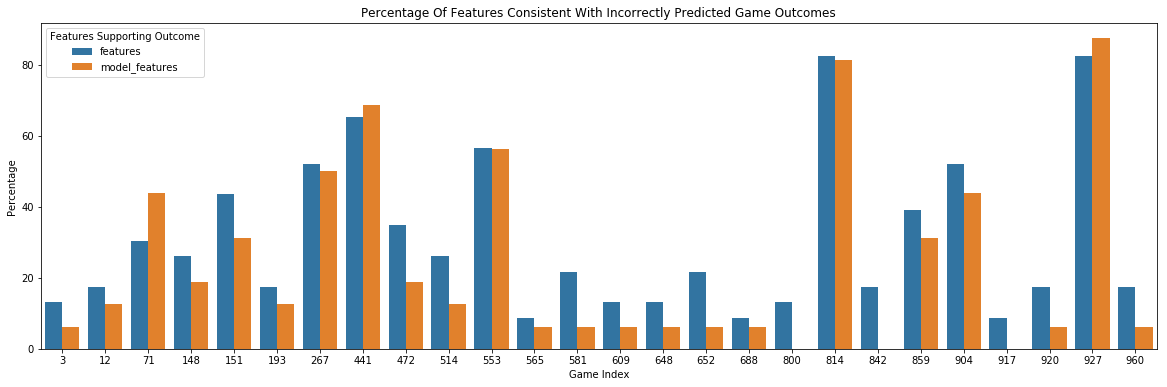

In [57]:
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Incorrectly Predicted Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Game Index')
m_plot.figure.set_size_inches(20,6)

##### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.